In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Conv2D, Dense, Flatten, Add, Input, BatchNormalization, ReLU, Activation, Layer
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.models import Model
from matplotlib import pyplot as plt
from IPython import display
import datetime
import h5py
from PIL import Image
import glob
import imageio
 
# Load the TensorBoard notebook extension
%load_ext tensorboard
%matplotlib inline

In [2]:
!pip install -q git+https://github.com/tensorflow/docs 

     |████████████████████████████████| 1.0MB 14.4MB/s 


In [3]:
    from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
img_height = 224
img_width = 224
batch_size = 1

train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/gan-dataset/Plastic/3layer/mnist/training'
test_data_dir = '/content/gdrive/My Drive/Colab Notebooks/gan-dataset/256mnist/testing'

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  color_mode='grayscale',
  subset="training",
  seed=123,shuffle='True',
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
train_image_batch, train_labels_batch = next(iter(normalized_train_ds))
test_image_batch, train_labels_batch = next(iter(normalized_test_ds)) 


(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

target_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(60000)
target_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(1, drop_remainder=True)
normalized_target_ds = target_dataset.map(lambda x, y: (normalization_layer(x), y))
target_image_batch, labels_batch = next(iter(target_dataset)) 

Found 5000 files belonging to 10 classes.
Using 4000 files for training.
Found 500 files belonging to 10 classes.
11493376/11490434 [==============================] - 0s 0us/step


In [5]:
def generator():
    generator_inputs = Input(shape=(224,224,1))
    x = Conv2D(128,(3,3),padding='same')(generator_inputs)
    x = Activation('relu')(x)
    x_1 = x
   
    #residual blocks
    for i in range(16):
        y = Conv2D(128,(3,3),padding='same')(x)
        y = BatchNormalization(momentum=0.5)(y)
        y = Activation('relu')(y)
        y = Conv2D(128,(3,3),padding='same')(y)
        y = BatchNormalization(momentum=0.5)(y)
        y = Add()([x,y])
        x = y
       
    x = Conv2D(128,(3,3),padding='same')(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = Add()([x,x_1])
   
    x = Conv2D(64,(3,3),strides=(2,2),padding='same')(x)
    x = Conv2D(32,(3,3),strides=(2,2),padding='same')(x)
    x = Conv2D(16,(3,3),strides=(2,2),padding='same')(x)
    x = Conv2D(1,(3,3),strides=(1,1),padding='same')(x)
    x = Activation('relu')(x)
   
    generator_outputs = x
    generator_model = Model(inputs=generator_inputs, outputs=generator_outputs, name='generator')
  
  
    return generator_model

generator = generator()

In [6]:
def discriminator():
    #initializer = tf.random_normal_initializer(0., 0.02)

    #inp = tf.keras.layers.Input(shape=[28, 28, 1], name='input_image')
    #tar = tf.keras.layers.Input(shape=[28, 28, 1], name='target_image')

    #x = tf.keras.layers.concatenate([inp, tar])

    discriminator_inputs = Input(shape=[28, 28, 1])
    x = Conv2D(64,(3,3),strides=(1,1),padding='same')(discriminator_inputs)
    x = Activation('relu')(x)
   
    x = Conv2D(64,(3,3),strides=(2,2),padding='same')(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = Activation('relu')(x)
   
    x = Conv2D(128,(3,3),strides=(1,1),padding='same', activation='relu')(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = Activation('relu')(x)
 
    x = Conv2D(128,(3,3),strides=(2,2),padding='same', activation='relu')(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = Activation('relu')(x)
 
    x = Conv2D(256,(3,3),strides=(1,1),padding='same', activation='relu')(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = Activation('relu')(x)
 
    x = Conv2D(256,(3,3),strides=(2,2),padding='same', activation='relu')(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = Activation('relu')(x)
   
    x = Conv2D(512,(3,3),strides=(1,1),padding='same', activation='relu')(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = Activation('relu')(x)
   
    x = Conv2D(512,(3,3),strides=(2,2),padding='same', activation='relu')(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = Activation('relu')(x)
   
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
   
    x = Dense(1,activation='sigmoid')(x)
   
    discriminator_outputs = x
    discriminator_model = Model(inputs=discriminator_inputs, outputs=discriminator_outputs, name='discriminator')
   
    return discriminator_model
 
discriminator = discriminator()

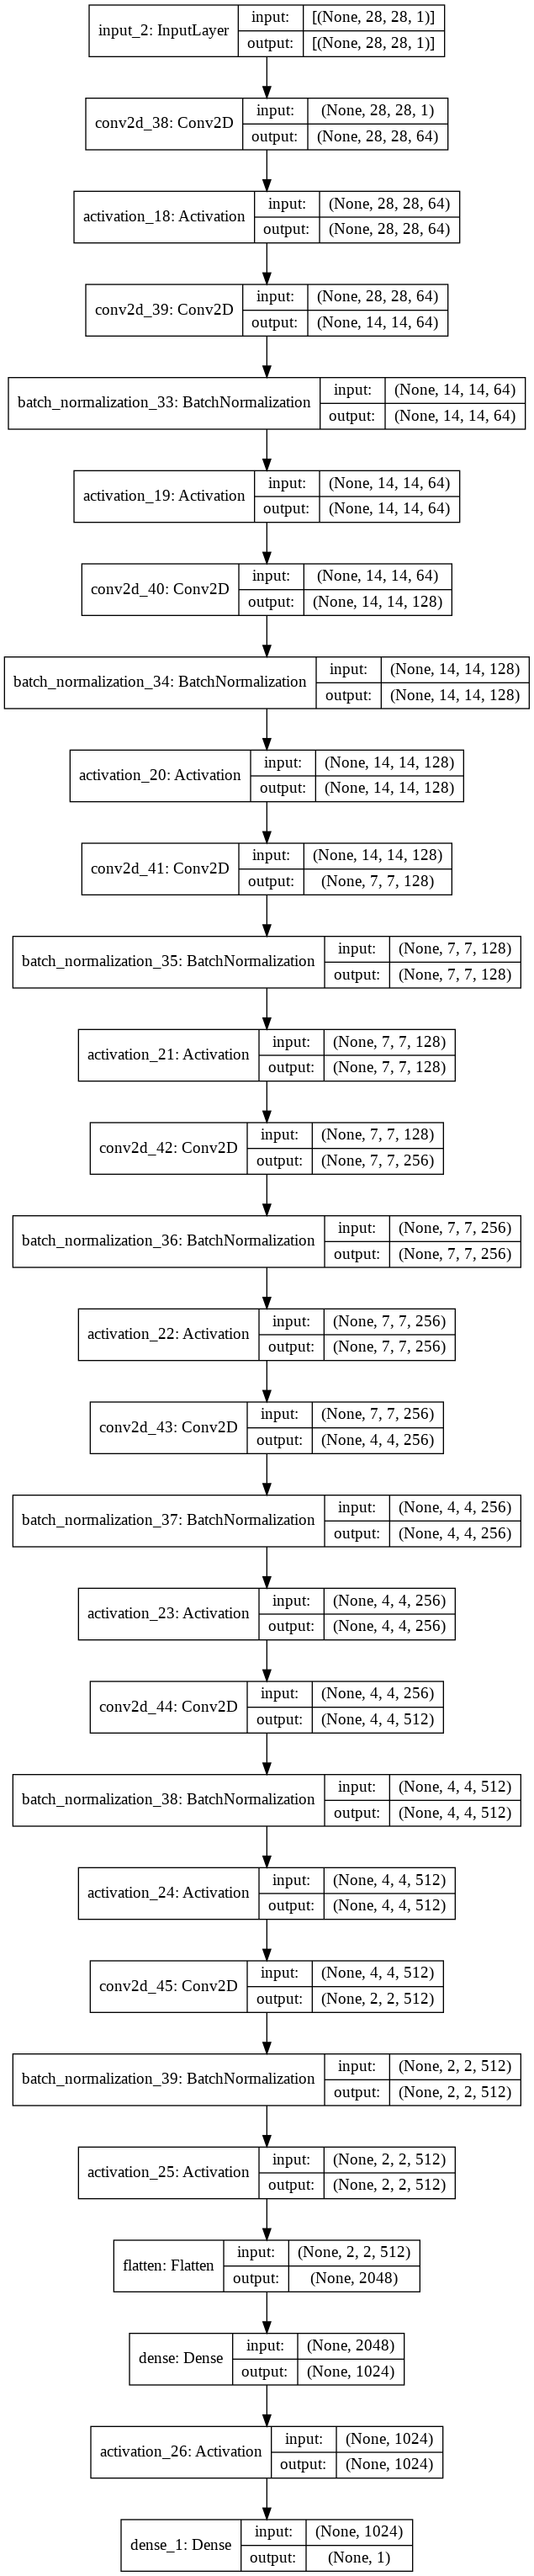

In [7]:
tf.keras.utils.plot_model(
    discriminator, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)


In [8]:
#define loss
MSE = tf.keras.losses.MeanSquaredError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
alpha = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=None)
def discriminator_loss(disc_real_output, disc_fake_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = cross_entropy(tf.zeros_like(disc_fake_output), disc_fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(disc_fake_output, gen_output, target):
    total_loss = MSE(target, gen_output) + (cross_entropy(tf.ones_like(disc_fake_output), disc_fake_output))
    return total_loss

In [9]:
#define optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [10]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator, discriminator=discriminator)

In [11]:
def generate_and_save_images(model, epoch, input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(1, 1, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [12]:
EPOCHS = 10
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

@tf.function
def train_step(input, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_output = generator(train_image_batch, training=True)

      disc_real_output = discriminator(target_image_batch, training=True)
      disc_fake_output = discriminator(gen_output, training=True)

      gen_total_loss = generator_loss(disc_fake_output, gen_output, target_image_batch)
      disc_loss = discriminator_loss(disc_real_output, disc_fake_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
      tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
      tf.summary.scalar('disc_loss', disc_loss, step=epoch)  


def fit(train_ds, epochs, target_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    # Train
    for n, (image_batch, target_images) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(train_ds, target_dataset, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)
  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                          EPOCHS,
                          image_batch)


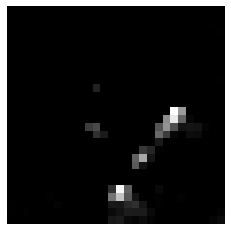

In [ ]:
fit(train_ds, EPOCHS, target_dataset)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>


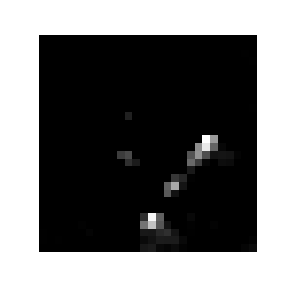

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:  
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)